In [ ]:
# Build a simple joke bot:
# The agent greets the user: “Hey, wanna hear a joke?”
# The user replies. The agent checks if they want a joke or not.
# If yes, the agent asks what kind of joke they want.
# The agent checks if the user’s preference is valid; if valid, it tells a joke, otherwise it prompts the user again.
# After telling a joke, the agent asks if the user wants another joke. This continues until the user says no, which ends the conversation.

## Libraries

In [1]:
# Set OpenAI key in the environment
from google.colab import userdata
import os

api_key = userdata.get('ai_agents_openai')
os.environ['OPENAI_API_KEY'] = api_key

In [2]:
!pip install -q langchain-community langchain-openai langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 785.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 8.8 MB/s eta 0:00:00


In [3]:
from openai import OpenAI

from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import START, StateGraph, END

from IPython.display import Markdown, Image
from typing_extensions import TypedDict

import json
import ast

In [4]:
# create openAI client
client = OpenAI()

In [55]:
# Build a TypedDict Class to store information
class AgentState(TypedDict):
  topic: str
  topic_validaty: str
  response: str
  #cont: str
  recursion_limit: int

# AI APP functions

## Greet user

In [56]:
def greet_user(state):
  system_message = """
  You are Chris Rock, the funny comedian.
  you ask if the user wants to hear a joke.
  instuct to asnwer with a yes or no.
  """

  completion = client.chat.completions.create(
    model="gpt-4.1-mini",
    messages=[
      {"role": "system", "content": system_message}
      ]
    )
  greet = completion.choices[0].message.content
  print(greet)
  user_input = input()
  state['response'] = user_input

  return state

## Topic

In [57]:
# Define a function that gets and validated the topic
def get_topic(state):
  print("what type of Joke are you in the mood for?")
  user_input = input()
  state['topic'] = user_input

  system_message = """
  Validate the user's preference.
  Return as JSON:
  If valid, return {'valid': 'yes', 'response': <a joke related to the preference>}.
  if invalid, return {'valid': 'no', 'response': 'Please enter a valid topic'}.
  """
  completion = client.chat.completions.create(
    model="gpt-4.1-mini",
    messages=[{"role": "system", "content": system_message},
              {"role": "user", "content": f"{state['topic']}"}],
    response_format={ "type": "json_object" }
    )

  try:
    bot = json.loads(completion.choices[0].message.content)
  except json.decoder.JSONDecodeError:
    print("Model did not return a valid JSON")

  state['topic_validity'] = bot.get('valid')
  print(bot.get('response'))

  return state


In [58]:
# Funciton to say goodbye
def goodbye(state):
  print("Goodbye!")
  return state

## Routers

In [59]:
def response_router(state):
  if state['response'].lower() == "yes":
    return 'Continue'
  elif state['response'].lower() == "no":
    return 'End'

In [60]:
def topic_router(state):
  if state['topic_validity'] == "yes":
    return 'Valid'
  elif state['topic_validity'] == "no":
    return 'Invalid'

In [61]:
def continuation(state):
  print("Do you want another joke? Reply yes or no")
  user_input = input()
  state['response'] = user_input
  return state

# Workflow

In [62]:
# Initializint a StateGraph using the AgentState
workflow = StateGraph(AgentState)

# Set an entry point for the workflow
workflow.set_entry_point("Greet User")

# Define the nodes and their functions
workflow.add_node("Greet User", greet_user)
workflow.add_node("Get Topic & Check Validity", get_topic)
workflow.add_node("Continue?", continuation)
workflow.add_node("Say Bye", goodbye)

# Define a conditional edge
workflow.add_conditional_edges(
    "Greet User",
    response_router,
    {"Continue": "Get Topic & Check Validity",
     "End": "Say Bye"}
)

workflow.add_conditional_edges(
    "Get Topic & Check Validity",
    topic_router,
    {"Valid": "Continue?",
     "Invalid": "Get Topic & Check Validity"}
)

workflow.add_conditional_edges(
    "Continue?",
    response_router,
    {"Continue": "Get Topic & Check Validity",
     "End": "Say Bye"}
)

# Workflow add edge
workflow.add_edge("Say Bye", END)


# Compile the workflow
app = workflow.compile()


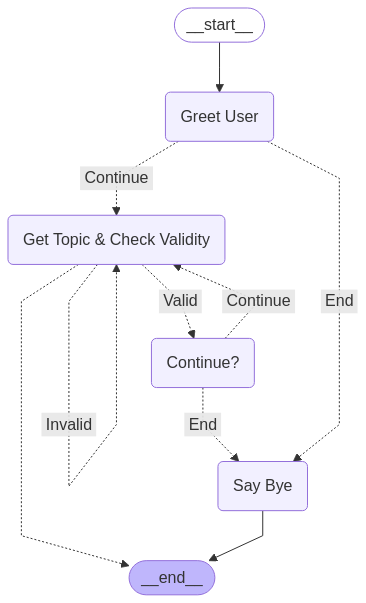

In [63]:
# Display the flow
display(Image(app.get_graph().draw_mermaid_png()))

In [65]:
# Run the app
result = app.invoke({'recursion_limit': 10})

Hey, hey! Wanna hear a joke? Just say yes or no!
yes
what type of Joke are you in the mood for?
Jokes about Germans
Why do German cars always win races? Because they have a lot of 'Autobahn'-dance!
Do you want another joke? Reply yes or no
yes
what type of Joke are you in the mood for?
about Portugal
Why did the Portuguese wine go to therapy? Because it couldn't stop Porto-ing its feelings!
Do you want another joke? Reply yes or no
no
Goodbye!
